In [ ]:
import numpy as np
import os
import pandas as pd
import random
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Loading Data and Reshape it to My Desire Format

In [ ]:
def read_files_function(sub_file_dir):
    # Input: file direction
    # Output: data: EEG Data (num_trials(2048)*num_channels(64)*trial_length(240)), 
    #               trial_inf: trials' tag (num_trials(2048)*3 (3=number of image classifiers))
    
    # Check File Directory
    if os.path.exists(sub_file_dir):
        # Loading Data and Trials Information
        input_file = sio.loadmat(sub_file_dir)
        data_file = input_file['data_rej_channel_interpolated_timelocked'][0] #numpy
        trial_inf = data_file['trialinfo'][0] #numpy
        data = data_file['trial'][0] #numpy
        
    else:
        print("File Not Found!")
    
    return data, trial_inf

In [ ]:
def reshape_data (data,trial_inf,num_image_catg,num_trial_pair_catg,analysis_idx):
    """
    Organizes and reshapes EEG data based on image category and trial information.
    Parameters:
    - data (np.ndarray): EEG signal data with shape (num_trials, num_channels, trial_length).
    - trial_inf (np.ndarray): Array with shape (num_trials, 3), holding trial tags (e.g., image classifiers like pairs, categories, supra-categories).
    - num_image_catg (int): Number of image categories for analysis.
    - num_trial_pair_catg (int): Expected number of trials per category for analysis.
    - analysis_idx (int): Index to use in `trial_inf` to filter by (0: pairs, 1: category, 2: supra-category).
    Returns:
    - np.ndarray: Reshaped EEG data array of shape (num_image_catg, num_trial_pair_catg, num_channels, trial_length).
    """
    
    # Initialize Parameters
    trial_len = data.shape[2]
    num_channel = data.shape[1]
    trial_data = np.zeros((num_image_catg, num_trial_pair_catg, num_channel, trial_len))
    
     # Reshape data based on category and trial information
    for i in range(num_image_catg):
        # Check if the number of trials matches the required amount
        idx = np.where(trial_inf[:, analysis_idx] == i + 1)[0].astype(int) 
        # Consider equal number of trials for all images and subjects
        if len(idx) > num_trial_pair_catg:
            # Randomly remove excess trials
            delte_trial_idx = random.sample(range(len(idx)), len(idx)-num_trial_pair_catg)
            idx = np.delete(idx, delte_trial_idx)
        # Store reshaped data for the current category
        trial_data[i,:,:,:] = data[idx,:,:]
           
    return trial_data

In [ ]:
def extract_pseudo_trials(data, num_image_catg, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, 
                          trial_len, num_trial_pair_catg, group_sub):  
    """"
    Divide trials to pseudo-trials and average over trials to increase signal-to-noise ratio (SNR).
    Parameters:
    - data (pd.DataFrame): Contains reshaped EEG data for each subject. Each row corresponds to a subject with 'Subject' and 'Data' columns.
    - num_image_catg (int): Number of image categories for analysis.
    - num_pseudo_trials (int): Number of pseudo-trials to create for each image category.
    - num_trials_pair_pseudo_trials (int): Number of trials within each pseudo-trial group.
    - num_channel (int): Number of EEG channels.
    - trial_len (int): Time length of each trial.
    - num_trial_pair_catg (int): Number of trials available for each image category.
    - group_sub (List[int]): List of subject indices grouped by age or condition (e.g., old/young).

    Returns:
    - np.ndarray: Pseudo-trial data array of shape 
                  (num_image_catg, num_pseudo_trials * len(group_sub), num_channel, trial_len).
    """
    # Initialize the output array to hold averaged pseudo-trial data
    pseudo_trial_data = np.zeros((num_image_catg, num_pseudo_trials*len(group_sub), num_channel, trial_len))
    # Loop over each subject in the group
    for sub_index, sub_id in enumerate(group_sub):
        # Extract the EEG data for the current subject from the DataFrame
        image_data = data.loc[data['Subject'] == sub_id + 1, 'Data'].values[0]
        count = sub_index * num_pseudo_trials  # Index for storing the subject's data in the output

        # Process each image category for the current subject
        for image in range(num_image_catg):
            print(f"Subject: {sub_id}, Image Category: {image + 1}")

            # Step 1: Shuffle and split trials into groups for creating pseudo-trials
            trials = np.arange(num_trial_pair_catg)  # Create a range of trial indices
            np.random.shuffle(trials)  # Shuffle the trials to randomize grouping
            selected_trials = np.array(np.split(trials, num_trials_pair_pseudo_trials), dtype=int)

            # Step 2: Average trials within each pseudo-trial group to increase SNR
            for j in range(num_pseudo_trials):
                pseudo_trial_data[image, count + j, :, :] = np.mean(image_data[image, selected_trials[:, j], :, :], axis=0)
    
    return pseudo_trial_data

In [ ]:
def eeg_classification(num_permutation, group_sub, group_num, img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image):
    
    """
    Classifies EEG data based on image categories and time points, using an SVM model

    Parameters:
    - num_permutation (int): Number of permutations to create pseudo-trials.
    - group_sub (List[int]): Subject group indices.
    - group_num (int): Number of subjects in each group.
    - img_index (List[int]): Indices of selected image categories.
    - trial_len_reduced (int): Reduced length of trials for faster analysis.
    - df_subject_data (pd.DataFrame): Dataframe containing subject-specific EEG data.
    - num_image (int): Number of image categories.
    - num_pseudo_trials (int): Number of pseudo-trials to create for each image category.
    - num_trials_pair_pseudo_trials (int): Number of trials per pseudo-trial.
    - num_channel (int): Number of EEG channels.
    - trial_len (int): Full time length of each trial.
    - num_trial_pair_image (int): Number of trials available per image category.

    Returns:
    - np.ndarray: Accuracy scores array with shape (num_permutation, len(img_index), len(img_index), trial_len_reduced).
    """
    # Initialize the accuracy results array
    Acc = np.zeros((num_permutation, len(img_index), len(img_index), trial_len_reduced))
     # Main loop over permutations
    for perm in range(num_permutation):
        # Step 1: Generate pseudo-trials
        pseudo_trial_data = extract_pseudo_trials(df_subject_data, num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, 
                                                trial_len, num_trial_pair_image, group_sub) #(num_image_catg, num_pseudo_trials * len(group_sub), num_channel, trial_len)
        # Step 2: Iterate over image pairs for classification
        for i, img1 in enumerate(img_index):
            for j in range(i+1, len(img_index)):
                img2 = img_index[j]
                # Step 3: Loop through time points
                for time in range(trial_len_reduced):
                    print(f"Training Model on images {img1} and {img2} at time point {time}")
                    
                    # Define training and test data for the SVM model
                    train_image1 = pseudo_trial_data[img1, :, :, time]
                    train_image2 = pseudo_trial_data[img2, :, :, time]     
                    training_data = np.concatenate((train_image1,train_image2), axis=0)
                    
                    # Create training labels
                    label_train1 = np.ones((group_num*num_pseudo_trials,1)); 
                    label_train2 = np.ones((group_num*num_pseudo_trials,1))*2
                    training_label = np.concatenate((label_train1,label_train2), axis=0).ravel()
                    
                    # Split data into training and testing sets
                    X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, test_size=0.3, random_state=109)
                    
                    # Step 4: Initialize and train SVM model
                    model = svm.SVC(kernel='linear')
                    model.fit(X_train, y_train)
                    
                    # Step 5: Predict and store accuracy for the current permutation, image pair, and time point
                    y_pred = model.predict(X_test)
                    Acc[perm, i, j, time] = metrics.accuracy_score(y_test, y_pred)

    return Acc                                  

Image Classification

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 64
num_trial_pair_image = 32
num_pseudo_trials = 8
analysis_idx= 0 # pair images
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data = pd.DataFrame(all_subject_data)


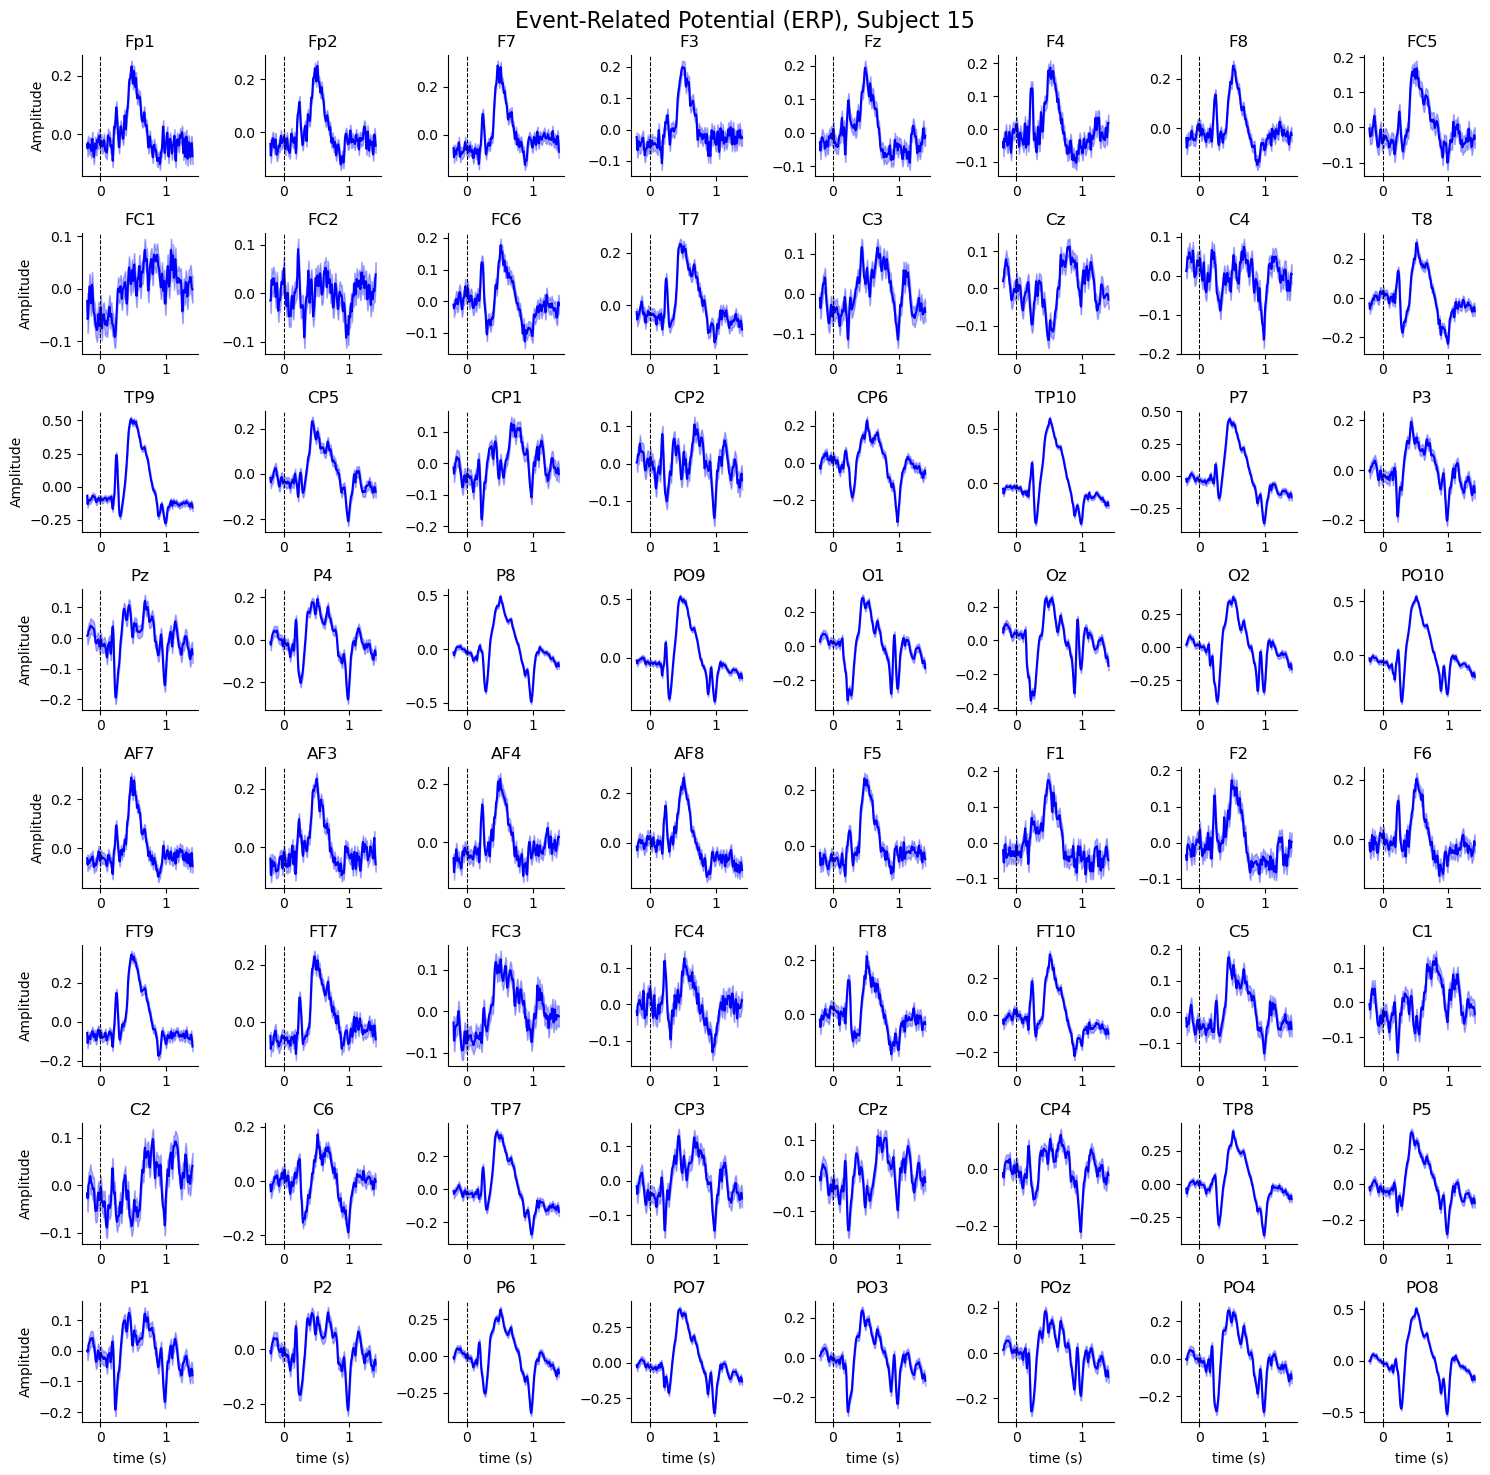

In [ ]:
# Plot ERP to check accuracy
# Channel names for each EEG channel (64 total)
channel_names = ['Fp1','Fp2','F7','F3','Fz','F4','F8','FC5','FC1','FC2','FC6','T7','C3','Cz','C4','T8','TP9','CP5','CP1','CP2','CP6','TP10',
                 'P7','P3','Pz','P4','P8','PO9','O1','Oz','O2','PO10','AF7','AF3','AF4','AF8','F5','F1','F2','F6','FT9','FT7','FC3','FC4',
                 'FT8','FT10','C5','C1','C2','C6','TP7','CP3','CPz','CP4','TP8','P5','P1','P2','P6','PO7','PO3','POz','PO4','PO8']
selected_sub_idx = 15   #Index of the subject data to be plotted
selected_sub_data = df_subject_data.loc[selected_sub_idx,'Data']   #Extract selected subject data
selected_sub_data_reshape = np.reshape(selected_sub_data, (64*32,64,240))    # Reshape to (all trials, channels, time points)
count = 0

# Set up figure with subplots for each channel
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
time = np.linspace(-0.2, 1.4, 240)  # Time points for x-axis

for i in range(8):
   for j in range(8):
         # Calculate mean and standard deviation across trials for the current channel
        mean_data = np.mean(selected_sub_data_reshape[:,count,:], axis=0)
        std_data = np.std(selected_sub_data_reshape[:,count,:], axis=0)/np.sqrt(selected_sub_data_reshape.shape[0])  

        ax[i,j].plot(time, mean_data, color='blue', label='Mean')  # Plot mean line
        ax[i,j].fill_between(time, mean_data - std_data, mean_data + std_data, color='blue', alpha=0.3, label='Mean ± Std')  # Shaded area
        ax[i,j].axvline(0, color='black', linestyle='--', linewidth=0.75)

        if i == 7: ax[i,j].set_xlabel('time (s)')
        if j == 0: ax[i,j].set_ylabel('Amplitude')
        ax[i,j].set_title(channel_names[i*8+j])
        
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)

        count += 1 # Move to the next channel


plt.tight_layout() 
fig.suptitle(f'Event-Related Potential (ERP), Subject {selected_sub_idx}', fontsize=16)
plt.subplots_adjust(top=0.95)  # Adjust space for the main title 


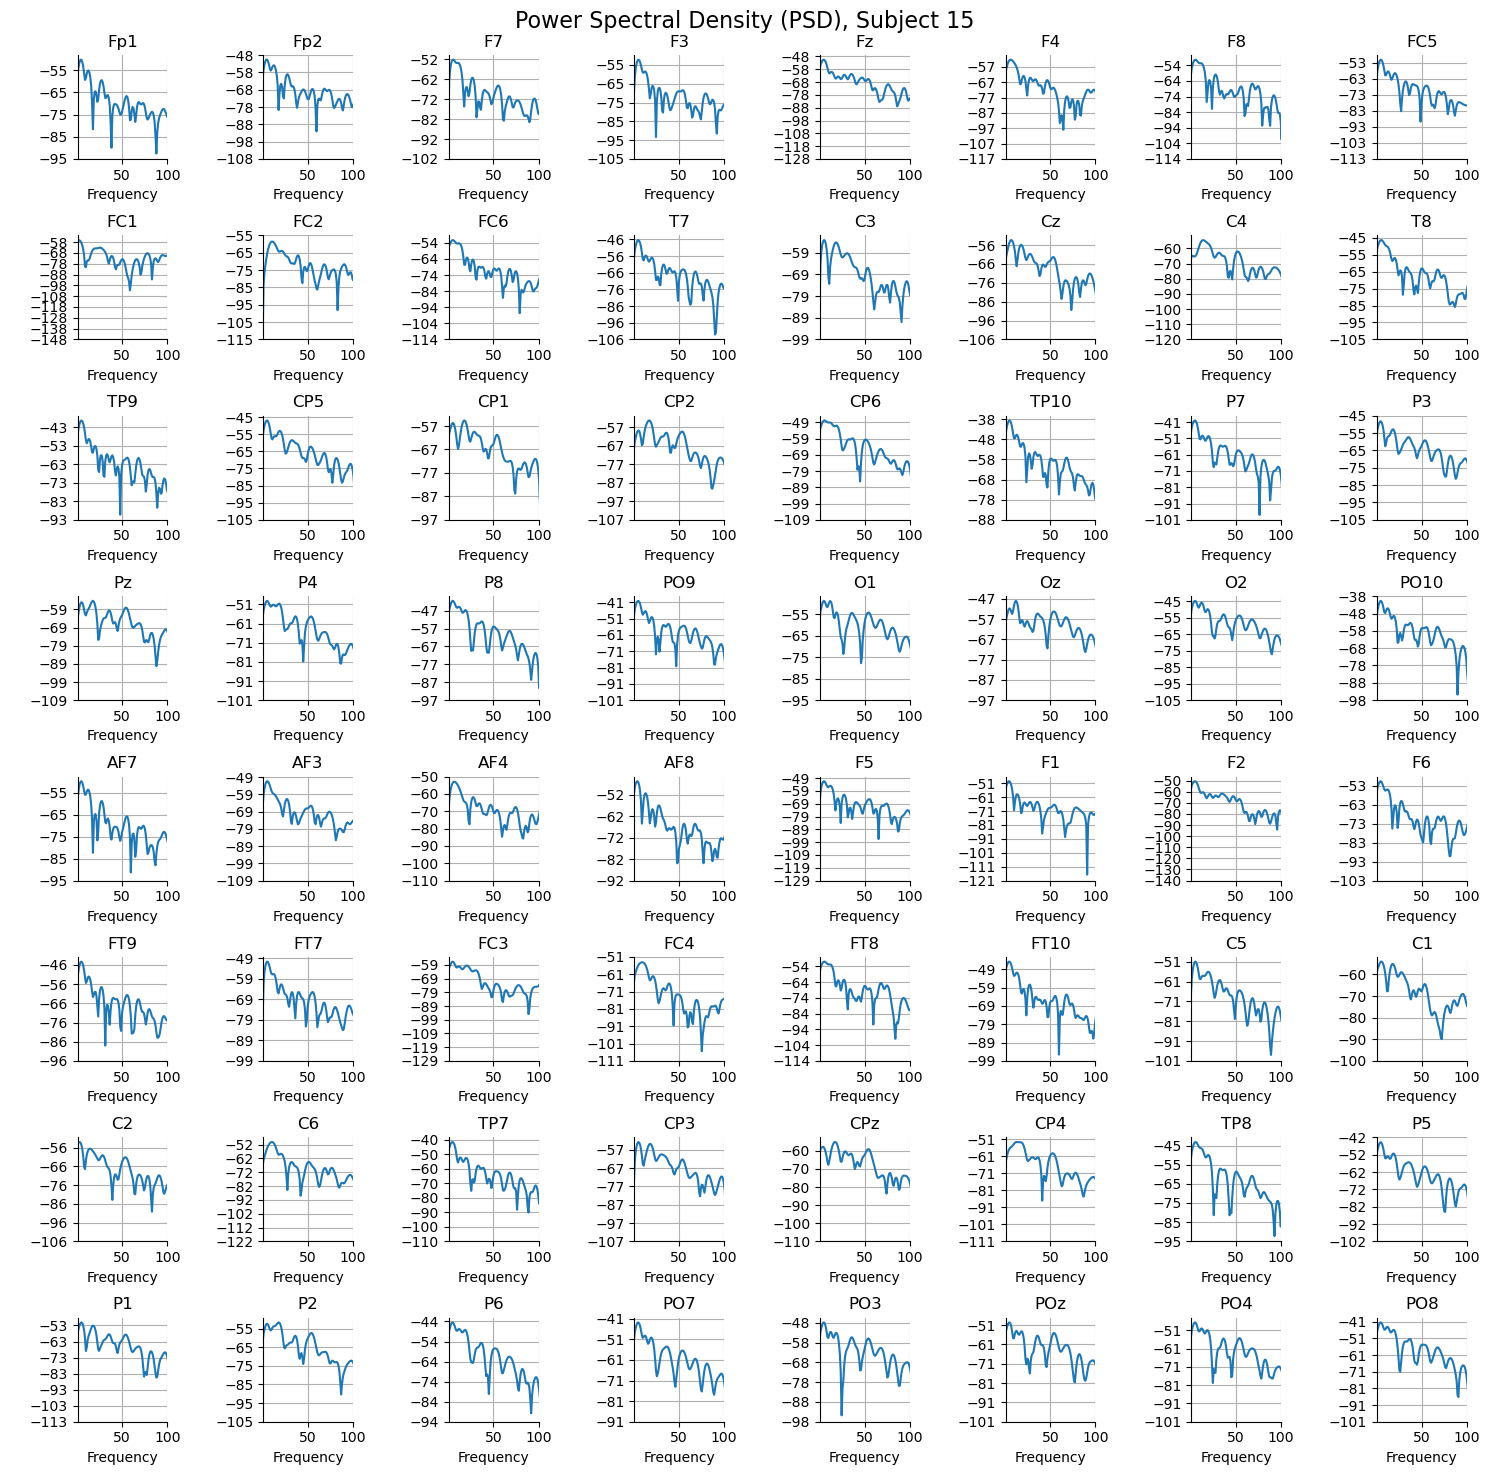

In [ ]:
# Plot PSD to check accuracy
selected_sub_idx = 15   #Index of the subject data to be plotted
selected_sub_data = df_subject_data.loc[selected_sub_idx,'Data']   #Extract selected subject data
selected_sub_data_reshape = np.reshape(selected_sub_data, (64*32,64,240))    # Reshape to (all trials, channels, time points)
count = 0

# Set up figure with subplots for each channel
fig, ax = plt.subplots(8, 8, figsize=(15, 15))
time = np.linspace(-0.2, 1.4, 240)  # Time points for x-axis

for i in range(8):
   for j in range(8):
         # Calculate mean and standard deviation across trials for the current channel
        mean_data = np.mean(selected_sub_data_reshape[:,count,:], axis=0)
        ax[i,j].psd(mean_data, NFFT=1024, Fs=1000, noverlap=100, scale_by_freq=True)

        ax[i,j].set_title(channel_names[i*8+j])
        
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].spines['top'].set_visible(False)
        
        ax[i,j].set_xlim(-40,-130)
        ax[i,j].set_xlim(0.5,100)
        ax[i, j].set_ylabel(' ')
        count += 1 # Move to the next channel


plt.tight_layout() 
fig.suptitle(f'Power Spectral Density (PSD), Subject {selected_sub_idx}', fontsize=16)
plt.subplots_adjust(top=0.95)  # Adjust space for the main title 



Time-Resolved EEG Classification

In [ ]:
num_permutation = 1
group1_sub = np.arange(1,20+1); group1_num = len(group1_sub)
group2_sub = np.arange(21,41+1); group2_num = len(group2_sub)
numbers = list(range(1,num_image))
seleted_img_index = random.sample(numbers, num_image//2) # number of category
trial_len = 240
trial_len_reduced = int(trial_len/2)
num_channel = 64

Acc1 = eeg_classification(num_permutation, group1_sub, group1_num, seleted_img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_First_Group_half_images.npy',Acc1) 

Acc2 = eeg_classification(num_permutation, group2_sub, group2_num, seleted_img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_Second_Group_half_images.npy',Acc2)   

Subject: 2, Image Category: 1
Subject: 2, Image Category: 2
Subject: 2, Image Category: 3
Subject: 2, Image Category: 4
Subject: 2, Image Category: 5
Subject: 2, Image Category: 6
Subject: 2, Image Category: 7
Subject: 2, Image Category: 8
Subject: 2, Image Category: 9
Subject: 2, Image Category: 10
Subject: 2, Image Category: 11
Subject: 2, Image Category: 12
Subject: 2, Image Category: 13
Subject: 2, Image Category: 14
Subject: 2, Image Category: 15
Subject: 2, Image Category: 16
Subject: 2, Image Category: 17
Subject: 2, Image Category: 18
Subject: 2, Image Category: 19
Subject: 2, Image Category: 20
Subject: 2, Image Category: 21
Subject: 2, Image Category: 22
Subject: 2, Image Category: 23
Subject: 2, Image Category: 24
Subject: 2, Image Category: 25
Subject: 2, Image Category: 26
Subject: 2, Image Category: 27
Subject: 2, Image Category: 28
Subject: 2, Image Category: 29
Subject: 2, Image Category: 30
Subject: 2, Image Category: 31
Subject: 2, Image Category: 32
Subject: 2, Image

In [ ]:
# num_permutation, len(img_index), len(img_index), trial_len_reduced
acc1_time = np.zeros(trial_len_reduced)
for time in range(trial_len_reduced):
    acc_values_perms = []
    for perm in range(num_permutation):
        upper_trig = np.triu(Acc1[perm, :, :, time], k=1)
        acc_values_perms.extend(upper_trig[upper_trig != 0])
        
    acc1_time[time] = np.mean(acc_values_perms)
        

acc2_time = np.zeros(trial_len_reduced)
for time in range(trial_len_reduced):
    acc_values_perms = []
    for perm in range(num_permutation):
        upper_trig = np.triu(Acc2[perm, :, :, time], k=1)
        acc_values_perms.extend(upper_trig[upper_trig != 0])
        
    acc2_time[time] = np.mean(acc_values_perms)    

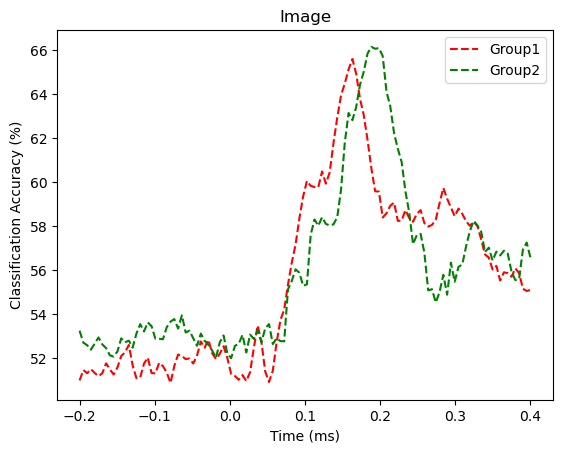

In [ ]:
t = np.linspace(-0.2, 0.4, trial_len_reduced)
plt.figure()
plt.plot(t, acc1_time*100, 'r--', label='Group1', linewidth=1.5)
plt.plot(t, acc2_time*100, 'g--', label='Group2', linewidth=1.5)
plt.xlabel('Time (s)')
plt.ylabel('Classification Accuracy (%)')
plt.title('Image')
plt.legend()
plt.show()

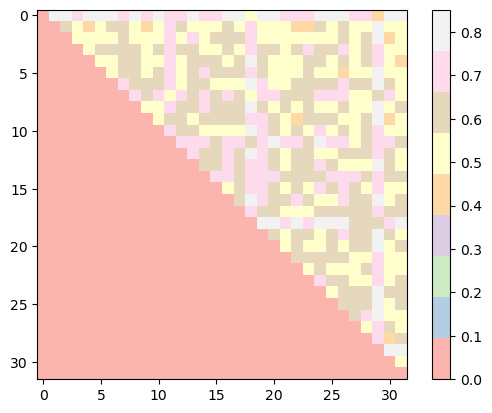

In [ ]:
plt.figure()
img = plt.imshow(Acc2[0,:,:,70], cmap='Pastel1')
plt.colorbar(img)

Category Classification

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 4
num_trial_pair_image = 32*16
#num_trial_pair_catg
num_pseudo_trials = 8*16
analysis_idx= 1 # pair category
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data2 = pd.DataFrame(all_subject_data)


Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
Subject 20
Subject 21
Subject 22
Subject 23
Subject 24
Subject 25
Subject 26
Subject 27
Subject 28
Subject 29
Subject 30
Subject 31
Subject 32
Subject 33
Subject 34
Subject 35
Subject 36
Subject 37
Subject 38
Subject 39
Subject 40
Subject 41
Subject 42
Subject 43


In [ ]:
num_permutation = 1
num_image = 4
group1_sub = np.arange(1,20+1); group1_num = len(group1_sub)
group2_sub = np.arange(21,41+1); group2_num = len(group2_sub)
numbers = list(range(1,num_image))
seleted_img_index = range(num_image)
#seleted_img_index = random.sample(numbers, num_image//2) # number of category
trial_len = 240
trial_len_reduced = int(trial_len/2)
num_channel = 64
num_trial_pair_image = 32*16
num_pseudo_trials = 8*16
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

Acc1 = eeg_classification(num_permutation, group1_sub, group1_num, seleted_img_index, trial_len_reduced, df_subject_data2, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_First_Group_Category.npy',Acc1) 

Acc2 = eeg_classification(num_permutation, group2_sub, group2_num, seleted_img_index, trial_len_reduced, df_subject_data2, 
                      num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_Second_Group_Category.npy',Acc2)   

Subject: 1, Image Category: 1
Subject: 1, Image Category: 2
Subject: 1, Image Category: 3
Subject: 1, Image Category: 4
Subject: 2, Image Category: 1
Subject: 2, Image Category: 2
Subject: 2, Image Category: 3
Subject: 2, Image Category: 4
Subject: 3, Image Category: 1
Subject: 3, Image Category: 2
Subject: 3, Image Category: 3
Subject: 3, Image Category: 4
Subject: 4, Image Category: 1
Subject: 4, Image Category: 2
Subject: 4, Image Category: 3
Subject: 4, Image Category: 4
Subject: 5, Image Category: 1
Subject: 5, Image Category: 2
Subject: 5, Image Category: 3
Subject: 5, Image Category: 4
Subject: 6, Image Category: 1
Subject: 6, Image Category: 2
Subject: 6, Image Category: 3
Subject: 6, Image Category: 4
Subject: 7, Image Category: 1
Subject: 7, Image Category: 2
Subject: 7, Image Category: 3
Subject: 7, Image Category: 4
Subject: 8, Image Category: 1
Subject: 8, Image Category: 2
Subject: 8, Image Category: 3
Subject: 8, Image Category: 4
Subject: 9, Image Category: 1
Subject: 9

In [ ]:
from scipy.stats import sem

c:\Users\Partiran\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [ ]:
# num_permutation, len(img_index), len(img_index), trial_len_reduced
acc1_time = np.zeros(trial_len_reduced)
acc2_time = np.zeros(trial_len_reduced)
acc1_ci = np.zeros(trial_len_reduced)
acc2_ci = np.zeros(trial_len_reduced)

for time in range(trial_len_reduced):
    acc_values_perms1 = []; acc_values_perms2 = []
    for perm in range(num_permutation):
        upper_trig = np.triu(Acc1[perm, :, :, time], k=1)
        acc_values_perms1.extend(upper_trig[upper_trig != 0]*100)
        upper_trig = np.triu(Acc2[perm, :, :, time], k=1)
        acc_values_perms2.extend(upper_trig[upper_trig != 0]*100)
        
    acc1_time[time] = np.mean(acc_values_perms1)
    acc1_ci[time] = np.std(acc_values_perms1)/np.sqrt(len(acc_values_perms1)) * 1.96
    acc2_time[time] = np.mean(acc_values_perms2)
    acc2_ci[time] = np.std(acc_values_perms2)/np.sqrt(len(acc_values_perms2)) * 1.96 

In [ ]:
t = np.linspace(-0.2, 0.4, trial_len_reduced)

acc1_peak_value = np.max(acc1_time)
acc1_peak_time = t[np.argmax(acc1_time)]
acc2_peak_value = np.max(acc2_time)
acc2_peak_time = t[np.argmax(acc2_time)]

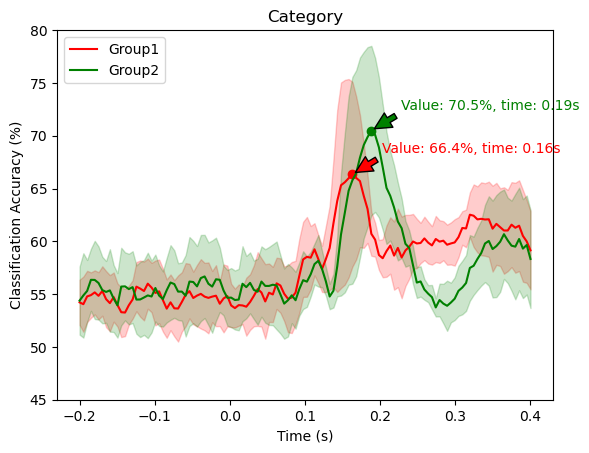

In [ ]:
plt.figure()
plt.plot(t, acc1_time, 'r', label='Young', linewidth=1.5)
plt.fill_between(t, (acc1_time-acc1_ci), (acc1_time+acc1_ci), color='red', alpha=0.2)
plt.plot(acc1_peak_time, acc1_peak_value, 'ro')
plt.annotate(f'Value: {acc1_peak_value:.1f}%, time: {acc1_peak_time:.2f}s', 
             xy = (acc1_peak_time, acc1_peak_value), 
             xytext = (acc1_peak_time + 0.04, acc1_peak_value + 2),
             arrowprops = dict(facecolor='red', shrink=0.1),
             color = 'red')

plt.plot(t, acc2_time, 'g', label='Old', linewidth=1.5)
plt.fill_between(t, (acc2_time-acc2_ci), (acc2_time+acc2_ci), color='green', alpha=0.2)
plt.plot(acc2_peak_time, acc2_peak_value, 'go')
plt.annotate(f'Value: {acc2_peak_value:.1f}%, time: {acc2_peak_time:.2f}s',
             xy=(acc2_peak_time, acc2_peak_value),
             xytext=(acc2_peak_time + 0.04, acc2_peak_value + 2),
             arrowprops= dict(facecolor='green', shrink=0.1),
             color = 'green')

plt.xlabel('Time (s)')
plt.ylabel('Classification Accuracy (%)')
plt.title('Category')
plt.legend(loc='upper left')
plt.ylim([45, 80])
plt.show()

# Add Difference Between Group
# If it is possible, run for the whole time.

Supra Classification

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 2
num_trial_pair_image = 32*32
#num_trial_pair_catg
num_pseudo_trials = 8*32
analysis_idx= 2 # pair supra category
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data3 = pd.DataFrame(all_subject_data)


Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
Subject 20
Subject 21
Subject 22
Subject 23
Subject 24
Subject 25
Subject 26
Subject 27
Subject 28
Subject 29
Subject 30
Subject 31
Subject 32
Subject 33
Subject 34
Subject 35
Subject 36
Subject 37
Subject 38
Subject 39
Subject 40
Subject 41
Subject 42
Subject 43


In [ ]:
num_permutation = 1
num_image = 2
group1_sub = np.arange(1,20+1); group1_num = len(group1_sub)
group2_sub = np.arange(21,41+1); group2_num = len(group2_sub)
numbers = list(range(1,num_image))
seleted_img_index = range(num_image)
#seleted_img_index = random.sample(numbers, num_image//2) # number of category
trial_len = 240
trial_len_reduced = int(trial_len/2)
num_channel = 64
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

Acc1 = eeg_classification(num_permutation, group1_sub, group1_num, seleted_img_index, trial_len_reduced, df_subject_data3, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_First_Group_Category.npy',Acc1) 

Acc2 = eeg_classification(num_permutation, group2_sub, group2_num, seleted_img_index, trial_len_reduced, df_subject_data3, 
                      num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_Second_Group_SupraCategory.npy',Acc2)   

Subject: 1, Image Category: 1
Subject: 1, Image Category: 2
Subject: 2, Image Category: 1
Subject: 2, Image Category: 2
Subject: 3, Image Category: 1
Subject: 3, Image Category: 2
Subject: 4, Image Category: 1
Subject: 4, Image Category: 2
Subject: 5, Image Category: 1
Subject: 5, Image Category: 2
Subject: 6, Image Category: 1
Subject: 6, Image Category: 2
Subject: 7, Image Category: 1
Subject: 7, Image Category: 2
Subject: 8, Image Category: 1
Subject: 8, Image Category: 2
Subject: 9, Image Category: 1
Subject: 9, Image Category: 2
Subject: 10, Image Category: 1
Subject: 10, Image Category: 2
Subject: 11, Image Category: 1
Subject: 11, Image Category: 2
Subject: 12, Image Category: 1
Subject: 12, Image Category: 2
Subject: 13, Image Category: 1
Subject: 13, Image Category: 2
Subject: 14, Image Category: 1
Subject: 14, Image Category: 2
Subject: 15, Image Category: 1
Subject: 15, Image Category: 2
Subject: 16, Image Category: 1
Subject: 16, Image Category: 2
Subject: 17, Image Categor

In [ ]:
# num_permutation, len(img_index), len(img_index), trial_len_reduced
acc1_time = np.zeros(trial_len_reduced)
acc2_time = np.zeros(trial_len_reduced)
acc1_ci = np.zeros(trial_len_reduced)
acc2_ci = np.zeros(trial_len_reduced)

for time in range(trial_len_reduced):
    acc_values_perms1 = []; acc_values_perms2 = []
    for perm in range(num_permutation):
        upper_trig = np.triu(Acc1[perm, :, :, time], k=1)
        acc_values_perms1.extend(upper_trig[upper_trig != 0]*100)
        upper_trig = np.triu(Acc2[perm, :, :, time], k=1)
        acc_values_perms2.extend(upper_trig[upper_trig != 0]*100)
        
    acc1_time[time] = np.mean(acc_values_perms1)
    acc1_ci[time] = np.std(acc_values_perms1)/np.sqrt(len(acc_values_perms1)) * 1.96
    acc2_time[time] = np.mean(acc_values_perms2)
    acc2_ci[time] = np.std(acc_values_perms2)/np.sqrt(len(acc_values_perms2)) * 1.96 

In [ ]:
t = np.linspace(-0.2, 0.4, trial_len_reduced)

acc1_peak_value = np.max(acc1_time)
acc1_peak_time = t[np.argmax(acc1_time)]
acc2_peak_value = np.max(acc2_time)
acc2_peak_time = t[np.argmax(acc2_time)]

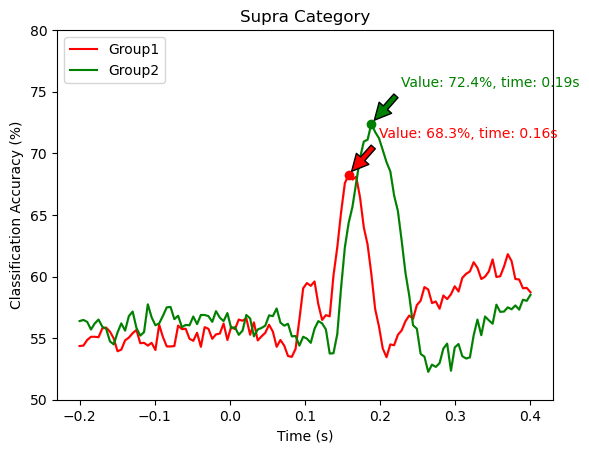

In [ ]:
plt.figure()
plt.plot(t, acc1_time, 'r', label='Group1', linewidth=1.5)
plt.fill_between(t, (acc1_time-acc1_ci), (acc1_time+acc1_ci), color='red', alpha=0.2)
plt.plot(acc1_peak_time, acc1_peak_value, 'ro')
plt.annotate(f'Value: {acc1_peak_value:.1f}%, time: {acc1_peak_time:.2f}s', 
             xy = (acc1_peak_time, acc1_peak_value), 
             xytext = (acc1_peak_time + 0.04, acc1_peak_value + 3),
             arrowprops = dict(facecolor='red', shrink=0.1),
             color = 'red')

plt.plot(t, acc2_time, 'g', label='Group2', linewidth=1.5)
plt.fill_between(t, (acc2_time-acc2_ci), (acc2_time+acc2_ci), color='green', alpha=0.2)
plt.plot(acc2_peak_time, acc2_peak_value, 'go')
plt.annotate(f'Value: {acc2_peak_value:.1f}%, time: {acc2_peak_time:.2f}s',
             xy=(acc2_peak_time, acc2_peak_value),
             xytext=(acc2_peak_time + 0.04, acc2_peak_value + 3),
             arrowprops= dict(facecolor='green', shrink=0.1),
             color = 'green')

plt.xlabel('Time (s)')
plt.ylabel('Classification Accuracy (%)')
plt.title('Supra Category')
plt.legend(loc='upper left')
plt.ylim([50, 80])
plt.show()

In [ ]:
num_image = 64
num_trials = 2048//4 #for each subject, after average each four trials
num_selected_trials = 20
num_sub = 41
num_permutation = 1
trial_len = 240
trial_len_reduced = int(trial_len/2)
num_channel = 64
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
fs = 1000


group1_sub = np.arange(1,20+1); group1_num = len(group1_sub)
group2_sub = np.arange(21,41+1); group2_num = len(group2_sub)
Data_all_subject_group1 = np.zeros((num_selected_trials*group1_num, num_image, trial_len_reduced))
Data_all_subject_group2 = np.zeros((num_selected_trials*group2_num, num_image, trial_len_reduced))
group1_index = 0; group2_index = 0

for sub_id in range(num_sub):
    print(f'Subject {sub_id+1}')
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    psudo_trial_data = np.reshape(data[0:2048,:,0:trial_len_reduced], (num_trials, 4, num_channel, trial_len_reduced)).mean(axis=1)
    
    if sub_id in group1_sub:
        selected_trials = random.sample(range(num_trials), num_selected_trials)
        Data_all_subject_group1[group1_index:group1_index+num_selected_trials,:,:] = psudo_trial_data[selected_trials, :, :]
        group1_index += num_selected_trials
    else:
        selected_trials = random.sample(range(num_trials), num_selected_trials)
        Data_all_subject_group2[group2_index:group2_index+num_selected_trials,:,:] = psudo_trial_data[selected_trials, :, :]
        group2_index += num_selected_trials 

Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
Subject 20
Subject 21
Subject 22
Subject 23
Subject 24
Subject 25
Subject 26
Subject 27
Subject 28
Subject 29
Subject 30
Subject 31
Subject 32
Subject 33
Subject 34
Subject 35
Subject 36
Subject 37
Subject 38
Subject 39
Subject 40
Subject 41


In [ ]:
Acc = np.zeros((num_permutation, trial_len_reduced))

for perm in range(num_permutation):
    for time in range(trial_len_reduced):
        print(f'Time: {time}')
        train_image1 = Data_all_subject_group1[:, :, time]
        train_image2 = Data_all_subject_group2[:, :, time]     
        training_data = np.concatenate((train_image1,train_image2), axis=0)

        # Create training labels
        label_train1 = np.ones((num_selected_trials*group1_num,1)); 
        label_train2 = np.ones((num_selected_trials*group2_num,1))*2
        training_label = np.concatenate((label_train1,label_train2), axis=0).ravel()

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, test_size=0.3, random_state=109)

        # Step 4: Initialize and train SVM model
        model = svm.SVC(kernel='linear')
        model.fit(X_train, y_train)

        # Step 5: Predict and store accuracy for the current permutation, image pair, and time point
        y_pred = model.predict(X_test)
        Acc[perm, time] = metrics.accuracy_score(y_test, y_pred)

Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20
Time: 21
Time: 22
Time: 23
Time: 24
Time: 25
Time: 26
Time: 27
Time: 28
Time: 29
Time: 30
Time: 31
Time: 32
Time: 33
Time: 34
Time: 35
Time: 36
Time: 37
Time: 38
Time: 39
Time: 40
Time: 41
Time: 42
Time: 43
Time: 44
Time: 45
Time: 46
Time: 47
Time: 48
Time: 49
Time: 50
Time: 51
Time: 52
Time: 53
Time: 54
Time: 55
Time: 56
Time: 57
Time: 58
Time: 59
Time: 60
Time: 61
Time: 62
Time: 63
Time: 64
Time: 65
Time: 66
Time: 67
Time: 68
Time: 69
Time: 70
Time: 71
Time: 72
Time: 73
Time: 74
Time: 75
Time: 76
Time: 77
Time: 78
Time: 79
Time: 80
Time: 81
Time: 82
Time: 83
Time: 84
Time: 85
Time: 86
Time: 87
Time: 88
Time: 89
Time: 90
Time: 91
Time: 92
Time: 93
Time: 94
Time: 95
Time: 96
Time: 97
Time: 98
Time: 99
Time: 100
Time: 101
Time: 102
Time: 103
Time: 104
Time: 105
Time: 106
Time: 107
Time: 108
Time: 109
Time: 110


In [ ]:
ACC.shape

NameError: name 'ACC' is not defined

In [ ]:
plt.figure()
plt.plot(time, ACC[0,:], color='r')
acc_max = np.max(ACC)
acc_max_time = time[np.argmax(ACC)]
plt.plot(acc_max_time, acc_max, 'ro', linewidth= 1.5)
plt.xlabel('Time (s)')
plt.ylabel('Accuracy (%)')
plt.show()

NameError: name 'ACC' is not defined

<Figure size 640x480 with 0 Axes>

Time Generalization

In [ ]:
# Define variables
file_dir = 'D:\\UBC\\Courses\\Dataset\\EEG'
num_sub = 43
fs = 1000
num_image = 2
num_trial_pair_image = 32*32
#num_trial_pair_catg
num_pseudo_trials = 8*32
analysis_idx= 2 # pair supra category
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

# Initialize lists to store subject data
all_subject_data = []
df_subject_data = pd.DataFrame()

# Process each subject's EEG data
for sub_id in range(num_sub):
    print(f"Subject {sub_id + 1}")
    
    # Step 1: Load subject's EEG data and stimulus order
    folder_name = f"sub{sub_id + 1:02d}"  # Format subject folder name
    sub_file_dir = os.path.join(file_dir, folder_name, 'stepxx_timelock.mat')  # File path for subject's EEG data
    data, trial_inf = read_files_function(sub_file_dir)  # Load data and trial information
    
    # Step 2: Reshape trials' data based on image indexes
    trial_data = reshape_data(data, trial_inf, num_image, num_trial_pair_image, analysis_idx)
    
    # Step 3: Normalize the trial data
    trial_data_normalized = zscore(trial_data, axis=-1)  # Z-score normalization across the last axis (time)
    
    # Step 4: Store normalized data
    subject_data = {
        'Subject': sub_id + 1,             # Subject identifier
        'Data': trial_data_normalized,     # Normalized EEG data
    }
    all_subject_data.append(subject_data)  # Append dictionary to list
    
# Convert list of subject data dictionaries to a DataFrame
df_subject_data3 = pd.DataFrame(all_subject_data)

In [ ]:
def eeg_classification_TimeGeneralization(num_permutation, group_sub, group_num, img_index, trial_len_reduced, df_subject_data, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image):
    
    """
    Classifies EEG data based on image categories and time points, using an SVM model

    Parameters:
    - num_permutation (int): Number of permutations to create pseudo-trials.
    - group_sub (List[int]): Subject group indices.
    - group_num (int): Number of subjects in each group.
    - img_index (List[int]): Indices of selected image categories.
    - trial_len_reduced (int): Reduced length of trials for faster analysis.
    - df_subject_data (pd.DataFrame): Dataframe containing subject-specific EEG data.
    - num_image (int): Number of image categories.
    - num_pseudo_trials (int): Number of pseudo-trials to create for each image category.
    - num_trials_pair_pseudo_trials (int): Number of trials per pseudo-trial.
    - num_channel (int): Number of EEG channels.
    - trial_len (int): Full time length of each trial.
    - num_trial_pair_image (int): Number of trials available per image category.

    Returns:
    - np.ndarray: Accuracy scores array with shape (num_permutation, len(img_index), len(img_index), trial_len_reduced).
    """
    # Initialize the accuracy results array
    Acc = np.zeros((num_permutation, len(img_index), len(img_index), trial_len_reduced))
     # Main loop over permutations
    for perm in range(num_permutation):
        # Step 1: Generate pseudo-trials
        pseudo_trial_data = extract_pseudo_trials(df_subject_data, num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, 
                                                trial_len, num_trial_pair_image, group_sub) #(num_image_catg, num_pseudo_trials * len(group_sub), num_channel, trial_len)
        # Step 2: Iterate over image pairs for classification
        for i, img1 in enumerate(img_index):
            for j in range(i+1, len(img_index)):
                img2 = img_index[j]
                # Step 3: Loop through time points
                for time1 in range(trial_len_reduced):
                    for time2 in np.arange(time1 + 1, trial_len_reduced):
                        print(f"Training Model on images {img1} and {img2} at time point {time1} and time point {time2}")
                        
                        # Define training and test data for the SVM model
                        train_image1 = pseudo_trial_data[img1, :, :, time1]
                        train_image2 = pseudo_trial_data[img2, :, :, time2]     
                        training_data = np.concatenate((train_image1,train_image2), axis=0)
                        
                        # Create training labels
                        label_train1 = np.ones((group_num*num_pseudo_trials,1)); 
                        label_train2 = np.ones((group_num*num_pseudo_trials,1))*2
                        training_label = np.concatenate((label_train1,label_train2), axis=0).ravel()
                        
                        # Split data into training and testing sets
                        X_train, X_test, y_train, y_test = train_test_split(training_data, training_label, test_size=0.3, random_state=109)
                        
                        # Step 4: Initialize and train SVM model
                        model = svm.SVC(kernel='linear')
                        model.fit(X_train, y_train)
                        
                        # Step 5: Predict and store accuracy for the current permutation, image pair, and time point
                        y_pred = model.predict(X_test)
                        Acc[perm, i, j, time1, time2] = metrics.accuracy_score(y_test, y_pred)

    return Acc                                  


In [ ]:
num_permutation = 1
num_image = 2
group1_sub = np.arange(1,20+1); group1_num = len(group1_sub)
group2_sub = np.arange(21,41+1); group2_num = len(group2_sub)
numbers = list(range(1,num_image))
seleted_img_index = range(num_image)
#seleted_img_index = random.sample(numbers, num_image//2) # number of category
trial_len = 240
trial_len_reduced = int(trial_len/2)
num_channel = 64
num_trials_pair_pseudo_trials = int(num_trial_pair_image / num_pseudo_trials)  # Trials per pseudo-trial group

Acc1 = eeg_classification_TimeGeneralization(num_permutation, group1_sub, group1_num, seleted_img_index, trial_len_reduced, df_subject_data3, 
                       num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_First_Group_Category.npy',Acc1) 

Acc2 = eeg_classification_TimeGeneralization(num_permutation, group2_sub, group2_num, seleted_img_index, trial_len_reduced, df_subject_data3, 
                      num_image, num_pseudo_trials, num_trials_pair_pseudo_trials, num_channel, trial_len, num_trial_pair_image)
np.save('Acc_Second_Group_SupraCategory.npy',Acc2)   

In [ ]:
for time1 in range(trial_len_reduced):
    for time2 in range(trial_len_reduced):
        acc_values_perms1 = []; acc_values_perms2 = []
        for perm in range(num_permutation):
            upper_trig = np.triu(Acc1[perm, :, :, time], k=1)
            acc_values_perms1.extend(upper_trig[upper_trig != 0]*100)
            upper_trig = np.triu(Acc2[perm, :, :, time], k=1)
            acc_values_perms2.extend(upper_trig[upper_trig != 0]*100)
            
        acc1_time[time] = np.mean(acc_values_perms1)
        acc1_ci[time] = np.std(acc_values_perms1)/np.sqrt(len(acc_values_perms1)) * 1.96
        acc2_time[time] = np.mean(acc_values_perms2)
        acc2_ci[time] = np.std(acc_values_perms2)/np.sqrt(len(acc_values_perms2)) * 1.96 